In [ ]:
"""Create parameters.py from a .inp and load it"""
# This cell is facultative, you can use an existing parameters.py

# Directory for .inp file:
path = 'F:\\OneDrive - Budapesti Műszaki és Gazdaságtudományi Egyetem\\TDK\\chemkin_AR_HE.inp'

# import libraries:
import importlib   # for reloading your own files
# my own files:
import inp_data_extractor as inp
importlib.reload(inp)

# create parameters.py
inp.extract(path)

# load parameters.py
import parameters as par
importlib.reload(par)
print(par.model)

In [44]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

import numpy as np   # matrices, math
import time   # runtime measurement
import os    # file management
from multiprocessing import Pool, cpu_count   # multithreading
import importlib   # reload changes you made

# my own file:
import full_bubble_model as de    # full bubble model
importlib.reload(de)   # reload changes you made

model: chemkin_AR_HE


<module 'full_bubble_model' from 'F:\\OneDrive - Budapesti Műszaki és Gazdaságtudományi Egyetem\\TDK\\Letisztázott programok\\full_bubble_model.py'>

## Single plot

You have one control parameter along the x axis, all the others are kept constant. <br>
The y axis is some output calculated from the simulation, like the amount of hydrogen created, energy put in. <br>
In this example: <br>
* **x**: Equilibrium radius or $R_E\ [\mu m]$ <br>
* **y**: Energy requirement for the production of 1 kg hydrogen or $E\ [MJ/kg]$ <br>

In [348]:
"""Control parameters"""

# Equilibrium radius: [um --> m]
parname = 'R_E'
ranges = [1e-6*x for x in list(np.linspace(0.1, 5.0, 25)) + list(np.linspace(6.0, 30.0, 25))]

# Other (constant) control parameters:
other_cpars = dict(
    R_E=5e-6, # [m]
    ratio=3.5, # [-]
    P_inf=50e5, # [Pa]
    alfa_M=0.05, # [-]
    T_inf=323.15, # [m]
    surfactant=1.0, # [-]
    gases=[de.par.index['AR']], # indexes of species in initial bubble
    fractions=[1.0] # molar fractions of species in initial bubble
)

# list all cpar combinations you want to plot:
cpars = []
for ID, value in enumerate(ranges):
    cpar = other_cpars.copy()  # deep copy other_cpars
    cpar[parname] = value
    cpar['ID'] = ID + 1
    cpar['P_v'] = de.VapourPressure(T=cpar['T_inf']) # [Pa]
    cpar['mu_L'] = de.Viscosity(T=cpar['T_inf']) # [Pa*s]
    cpars.append(cpar)
    
# Create input dictionary for de.simulate(), a list of dictionaries with cpar and other arguments
kwargs_list = [dict(cpar=cpar, t_int=np.array([0.0, 1.0]), LSODA_timeout=300, Radau_timeout=30) for cpar in cpars]

In [349]:
"""Run simulations, multithread"""
# calculate E [MJ/kg] for each R_E
# use Pool(processes=cpu_count()-1) to limit number of threads being used.
# use pool.imap(...) instead of pool.imap_unordered(...) to preserve order in which cpars was made

# empty lists to store values on x and y axises:
x = []
y = []

best_energy = 1e30
start = time.time()
with Pool(processes=cpu_count(), maxtasksperchild=100) as pool:
    results = pool.imap(de.simulate, kwargs_list)

    for data in results:
        # store results in x and y, if they are valid:
        data = de.dotdict(data)
        if data.error_code<4 and data.energy==data.energy: # if simulation is succesfull, and energy is not NaN
            if data.energy<0: data.energy=1e30
            x.append(data[parname])
            y.append(data.energy)
        # print stuff:
        if data.energy>0 and data.energy<best_energy:
            best_energy = data.energy
        print(f'index: {data.ID}/{len(cpars)},   error_code: {data.error_code},   steps: {data.steps},   runtime: {data.elapsed_time: .2f} [s]   |   '+
              f'R_E={1e6*data.R_E: .2f} [um]; ratio={data.ratio: .2f} [-]; P_inf={1e-5*data.P_inf: .2f} [bar]; alfa_M={data.alfa_M: .2f} [-]; '+
              f'T_inf={data.T_inf-273.15: .2f} [°C]; surfactant={100*data.surfactant: .0f} [%]   |   hydrogen production: {data.energy: .1f} [MJ/kg] '+
              f'(best: {best_energy: .1f} [MJ/kg])                                                 ', end='\r')
            
end = time.time()
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {(elapsed / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / len(cpars)): .2f} [s/run])')
print(f'succes: {len(x)}/{len(R_E_ranges)}')

index: 50/50,   error_code: 0,   steps: 23815,   runtime:  3.55 [s]   |   R_E= 30.00 [um]; ratio= 3.50 [-]; P_inf= 50.00 [bar]; alfa_M= 0.05 [-]; T_inf= 50.00 [°C]; surfactant= 100 [%]   |   hydrogen production:  14762.9 [MJ/kg] (best:  6683.7 [MJ/kg])                                                 )                                                 

DONE
total time:  0 hours  1 mins
             45.28 [s]   ( 0.91 [s/run])
succes: 50/50


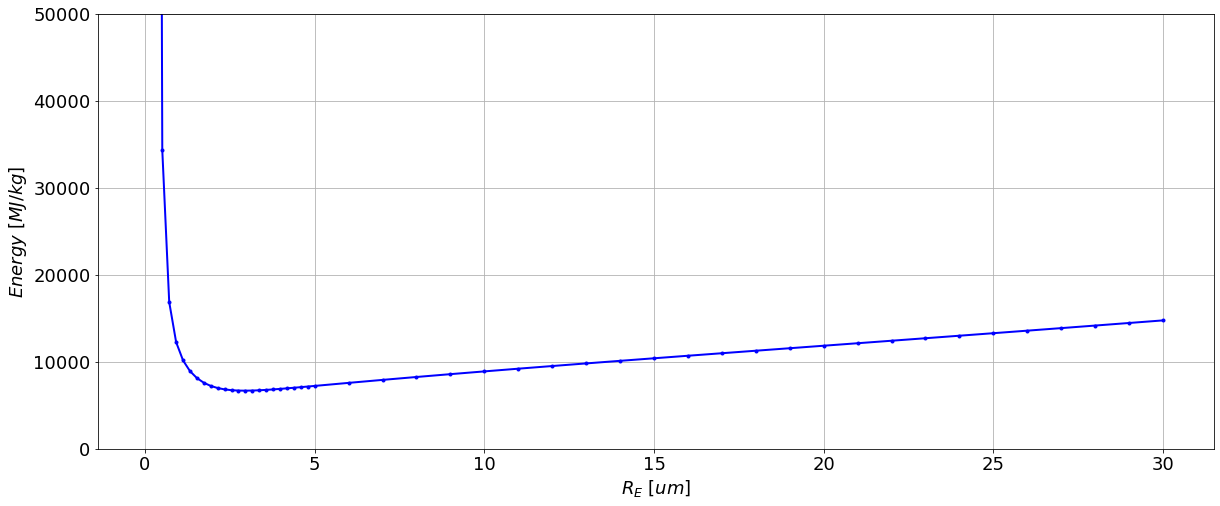

In [350]:
"""plot the results (and save it as .png)"""

plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(1e6*np.array(x), y, '.-', color='b', linewidth=2.0)
ax.set_ylabel('$Energy \ [MJ/kg]$')
ax.set_xlabel('$R_E \ [um]$')
ax.set_ylim([0, min(max(y), 5e4)])
#ax.set_yscale('log')
ax.grid()

if False: # save as image by setting it True (don't forget to create folder named 'images')
    fig.savefig('images\\R_E-Energy-plot.png')

## Subplots
You have a fixed point in the control parameter space, e.g. the global optimum for E [MJ/kg]. An each subplot, one control parameter is changed, similarly to the previous examply, while the rest remains constant. This way you can visualize
You have one control parameter along the x axis, all the others are kept constant. <br>
The y axis is the same, as before.

In [351]:
"""Control parameters"""

# point, which's environment you want to inspect:
fixed_point = dict(
    R_E=5e-6, # [m]
    ratio=3.5, # [-]
    P_inf=50e5, # [Pa]
    alfa_M=0.05, # [-]
    T_inf=323.15, # [m]
    surfactant=1.0, # [-]
    gases=[de.par.index['AR']], # indexes of species in initial bubble
    fractions=[1.0] # molar fractions of species in initial bubble
)

# control parameter points to examine:
ranges = dict(
    R_E=[1e-6*x for x in list(np.linspace(0.1, 5.0, 25)) + list(np.linspace(6.0, 30.0, 25))], # [um --> m]
    ratio=list(np.linspace(1.5, 5.0, 25)) + list(np.linspace(6.0, 30.0, 25)), # [-]
    P_inf=[1e5*x for x in np.linspace(1.0, 100.0, 100)], # [bar --> Pa]
    alfa_M=np.linspace(0.05, 0.4, 8), # [-]
    T_inf=[273.15+x for x in np.linspace(5.0, 50.0, 10)], # [°C --> K]
    surfactant=np.linspace(0.25, 1.0, 4), # [-]
)

# for plot labels:
labels = dict(
    R_E='$R_E\ [\mu m]$',
    ratio='$R_0/R_E\ [-]$',
    P_inf='$P_\infty\ [bar]$',
    alfa_M='$α_M\ [-]$',
    T_inf='$T_\infty\ [°C]$',
    surfactant='$surfactant\ [\%]$',
)

# list all cpar combinations you want to plot:
kwargs_list = []
ID = 1
for key in ranges:
    cpars = []
    for value in ranges[key]:
        cpar = fixed_point.copy()  # deep copy other_cpars
        cpar[key] = value
        cpar['ID'] = ID
        ID += 1
        cpar['P_v'] = de.VapourPressure(T=cpar['T_inf']) # [Pa]
        cpar['mu_L'] = de.Viscosity(T=cpar['T_inf']) # [Pa*s]
        cpars.append(cpar)
    # Create input dictionary for de.simulate(), a list of dictionaries with cpar and other arguments
    kwargs_list.append([dict(cpar=cpar, t_int=np.array([0.0, 1.0]), LSODA_timeout=300, Radau_timeout=30) for cpar in cpars])

In [352]:
"""Run simulations, multithread"""
# calculate E [MJ/kg] for each combinations
# use Pool(processes=cpu_count()-1) to limit number of threads being used.
# use pool.imap(...) instead of pool.imap_unordered(...) to preserve order in which cpars was made

# empty lists to store values on x and y axises:
x = []
y = []

fixed_energy = de.simulate(dict(cpar=cpar, t_int=np.array([0.0, 1.0]), LSODA_timeout=300, Radau_timeout=30))['energy']
best_energy = 1e30
num = sum([len(x) for x in kwargs_list])
start = time.time()
for i, key in enumerate(ranges):
    subx = []
    suby = []
    with Pool(processes=cpu_count(), maxtasksperchild=100) as pool:
        results = pool.imap(de.simulate, kwargs_list[i])

        for data in results:
            # store results in x and y, if they are valid:
            data = de.dotdict(data)
            if data.error_code<4 and data.energy==data.energy: # if simulation is succesfull, and energy is not NaN
                if data.energy<0: data.energy=1e30
                subx.append(data[key])
                suby.append(data.energy)
            # print stuff:
            if data.energy>0 and data.energy<best_energy:
                best_energy = data.energy
            print(f'index: {data.ID}/{num},   error_code: {data.error_code},   steps: {data.steps},   runtime: {data.elapsed_time: .2f} [s]   |   '+
                  f'R_E={1e6*data.R_E: .2f} [um]; ratio={data.ratio: .2f} [-]; P_inf={1e-5*data.P_inf: .2f} [bar]; alfa_M={data.alfa_M: .2f} [-]; '+
                  f'T_inf={data.T_inf-273.15: .2f} [°C]; surfactant={100*data.surfactant: .0f} [%]   |   hydrogen production: {data.energy: .1f} [MJ/kg] '+
                  f'(best: {best_energy: .1f} [MJ/kg])                                                 ', end='\r')
    x.append(subx)
    y.append(suby)
            
end = time.time()
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {(elapsed / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / num): .2f} [s/run])')
good = sum([len(x) for x in x])
print(f'succes: {good}/{num}')

index: 222/222,   error_code: 0,   steps: 14541,   runtime:  2.23 [s]   |   R_E= 5.00 [um]; ratio= 3.50 [-]; P_inf= 50.00 [bar]; alfa_M= 0.05 [-]; T_inf= 50.00 [°C]; surfactant= 100 [%]   |   hydrogen production:  7230.0 [MJ/kg] (best:  6683.7 [MJ/kg])                                                                                                    

DONE
total time:  0 hours  4 mins
             224.89 [s]   ( 1.01 [s/run])
succes: 222/222


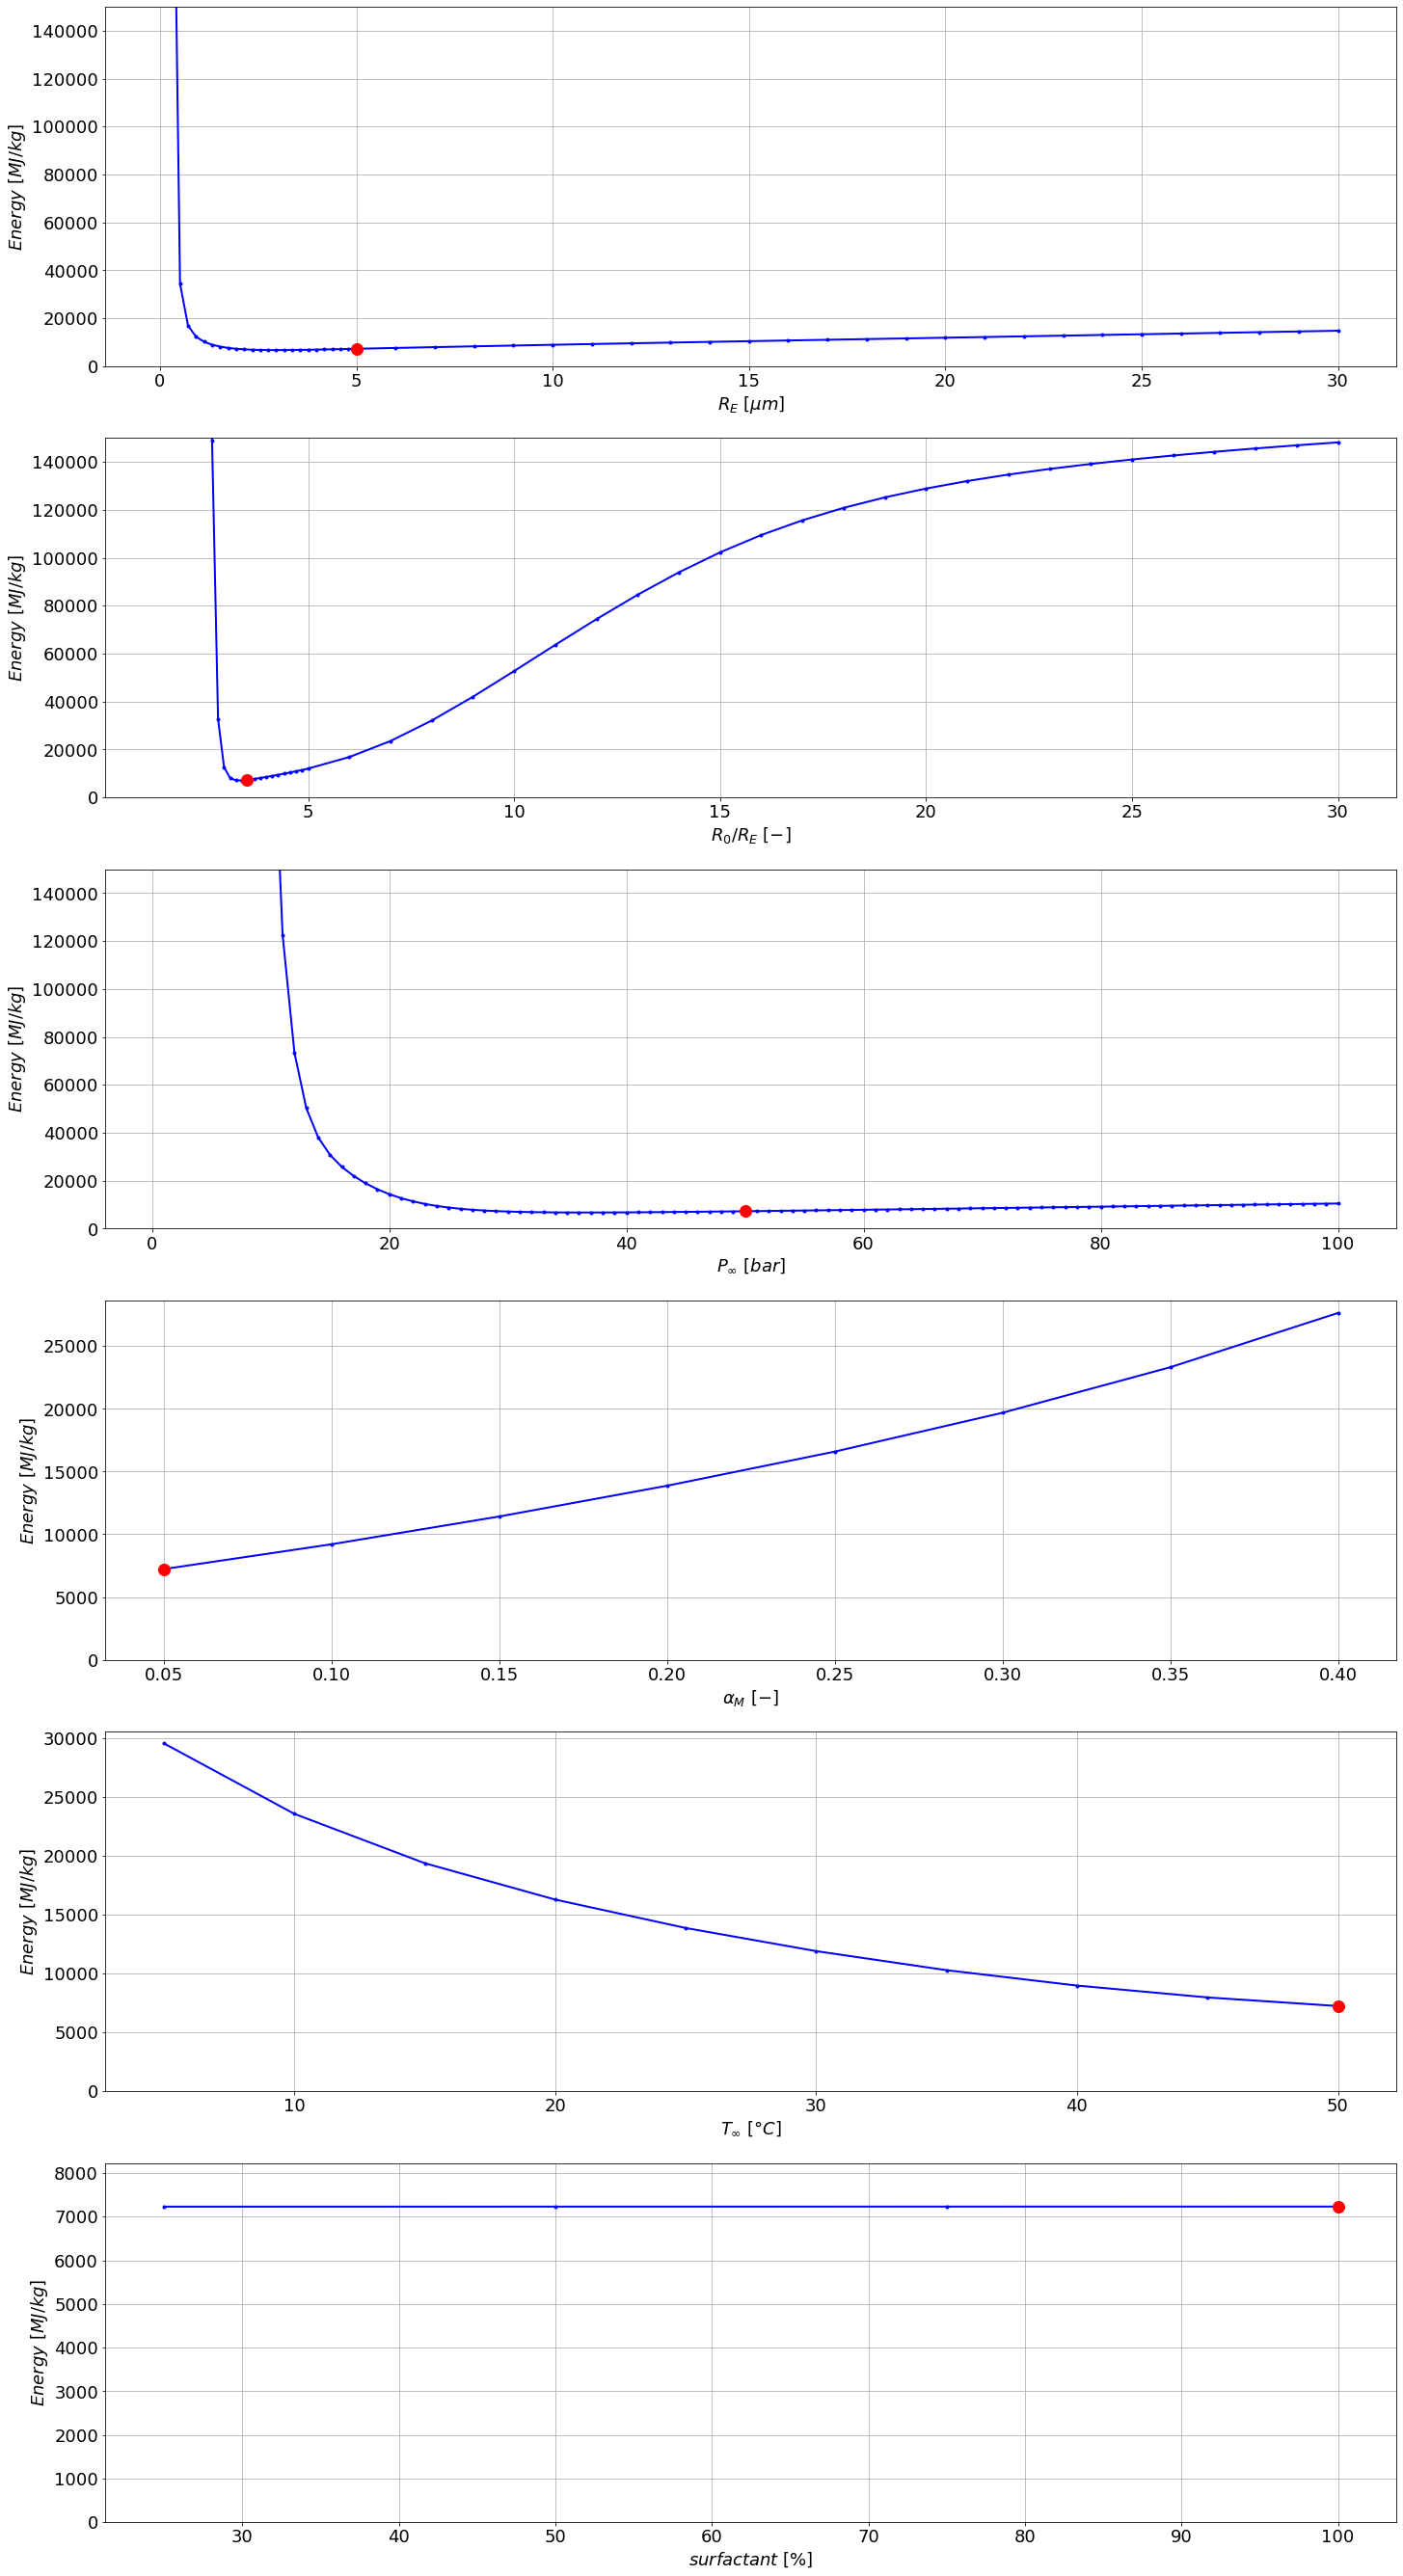

In [353]:
"""Plot the results (and save it as .png)"""

plt.rcParams.update({'font.size': 18})

n = len(kwargs_list)
fig, ax = plt.subplots(n, 1, figsize=(24, 8*n))
for i, key in enumerate(ranges):
    subx = x[i]
    suby = y[i]
    
  # unit corrections:
    correction1 = 1.0
    correction2 = 0.0
    if key=='R_E': correction1 = 1e6
    elif key=='P_inf': correction1 = 1e-5
    elif key=='T_inf': correction2 = -273.15
    elif key=='surfactant': correction1 = 100.0
    subx = correction1 * np.array(subx) + correction2
    
  # ploting:
    ax[i].plot(subx, suby, '.-', color='b', linewidth=2.0)
    ax[i].set_ylabel('$Energy \ [MJ/kg]$')
    ax[i].set_xlabel(labels[key])
    ax[i].set_ylim([0, min(max(suby)+1000, 1.5e5)])
    #ax[i].set_yscale('log')
    ax[i].grid()
  # add the red dot:
    ax[i].plot(correction1*fixed_point[key]+correction2, fixed_energy, markersize=12, marker="o", color='r')

if False: # save as image by setting it True (don't forget to create folder named 'images')
    fig.savefig('images\\R_E-Energy-plot.png')

## Multiple graphs on the same plot
In this example, you have one control parameter along the x axis, just like in the first example. But the effect of a second control parameter can be examined by creating multiple graphs, with different values of the second parameter. <br> 
In this example:

* **x**: Equilibrium radius or $R_E\ [\mu m]$ <br>
* **second cpar**: Ambient pressure or $P_\infty\ [bar]$ <br>
* **y**: Energy requirement for the production of 1 kg hydrogen or $E\ [MJ/kg]$ <br>

In [364]:
"""Control parameters"""

# Equilibrium radius: [um --> m]
parname1 = 'R_E'
ranges1 = [1e-6*x for x in list(np.linspace(0.1, 5.0, 20)) + list(np.linspace(6.0, 30.0, 20))]
# Ambient pressure: [bar --> Pa]
parname2 = 'P_inf'
ranges2 = [1e5*x for x in [10, 20, 30, 40, 50, 60, 70, 80]]

# Other (constant) control parameters:
other_cpars = dict(
    R_E=5e-6, # [m]
    ratio=3.5, # [-]
    P_inf=50e5, # [Pa]
    alfa_M=0.05, # [-]
    T_inf=323.15, # [m]
    surfactant=1.0, # [-]
    gases=[de.par.index['AR']], # indexes of species in initial bubble
    fractions=[1.0] # molar fractions of species in initial bubble
)

# list all cpar combinations you want to plot:
kwargs_list = []
ID = 1
for value2 in ranges2:
    cpars = []
    for value1 in ranges1:
        cpar = other_cpars.copy()  # deep copy other_cpars
        cpar[parname1] = value1
        cpar[parname2] = value2
        cpar['ID'] = ID
        ID += 1
        cpar['P_v'] = de.VapourPressure(T=cpar['T_inf']) # [Pa]
        cpar['mu_L'] = de.Viscosity(T=cpar['T_inf']) # [Pa*s]
        cpars.append(cpar)
    # Create input dictionary for de.simulate(), a list of dictionaries with cpar and other arguments
    kwargs_list.append([dict(cpar=cpar, t_int=np.array([0.0, 1.0]), LSODA_timeout=300, Radau_timeout=30) for cpar in cpars])

In [362]:
"""Run simulations, multithread"""
# calculate E [MJ/kg] for each combinations
# use Pool(processes=cpu_count()-1) to limit number of threads being used.
# use pool.imap(...) instead of pool.imap_unordered(...) to preserve order in which cpars was made

# empty lists to store values on x and y axises:
x = []
y = []

best_energy = 1e30
num = sum([len(x) for x in kwargs_list])
start = time.time()
for i in range(len(ranges2)):
    subx = []
    suby = []
    with Pool(processes=cpu_count(), maxtasksperchild=100) as pool:
        results = pool.imap(de.simulate, kwargs_list[i])

        for data in results:
            # store results in x and y, if they are valid:
            data = de.dotdict(data)
            if data.error_code<4 and data.energy==data.energy: # if simulation is succesfull, and energy is not NaN
                if data.energy<0: data.energy=1e30
                subx.append(data[parname1])
                suby.append(data.energy)
            # print stuff:
            if data.energy>0 and data.energy<best_energy:
                best_energy = data.energy
            print(f'index: {data.ID}/{num},   error_code: {data.error_code},   steps: {data.steps},   runtime: {data.elapsed_time: .2f} [s]   |   '+
                  f'R_E={1e6*data.R_E: .2f} [um]; ratio={data.ratio: .2f} [-]; P_inf={1e-5*data.P_inf: .2f} [bar]; alfa_M={data.alfa_M: .2f} [-]; '+
                  f'T_inf={data.T_inf-273.15: .2f} [°C]; surfactant={100*data.surfactant: .0f} [%]   |   hydrogen production: {data.energy: .1f} [MJ/kg] '+
                  f'(best: {best_energy: .1f} [MJ/kg])                                                 ', end='\r')
    x.append(subx)
    y.append(suby)
            
end = time.time()
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {(elapsed / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / num): .2f} [s/run])')
good = sum([len(x) for x in x])
print(f'succes: {good}/{num}')

index: 320/320,   error_code: 0,   steps: 17988,   runtime:  2.91 [s]   |   R_E= 30.00 [um]; ratio= 3.50 [-]; P_inf= 80.00 [bar]; alfa_M= 0.05 [-]; T_inf= 50.00 [°C]; surfactant= 100 [%]   |   hydrogen production:  20318.3 [MJ/kg] (best:  6665.0 [MJ/kg])                                                                                

DONE
total time:  0 hours  5 mins
             304.45 [s]   ( 0.95 [s/run])
succes: 320/320


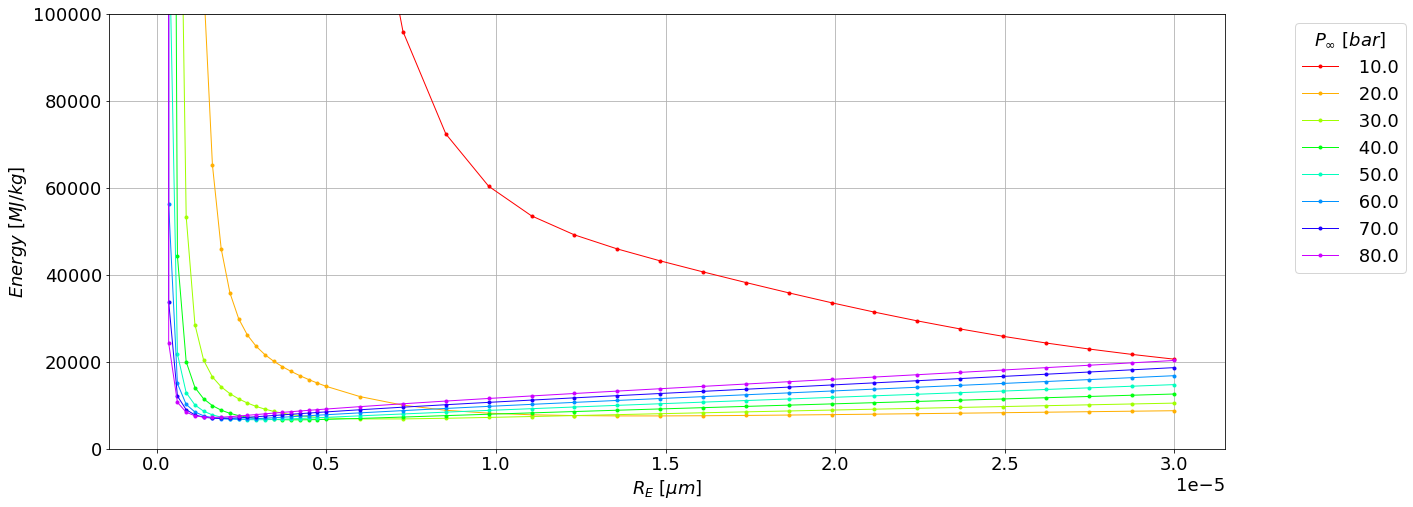

In [363]:
"""Plot the results (and save it as .png)"""

plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.set_ylabel('$Energy \ [MJ/kg]$')
ax.set_xlabel('$R_E \ [\mu m]$')
ax.set_ylim([0, 1e5])
#ax.set_yscale('log')
ax.grid()

delta = max(ranges2) - min(ranges2)
minimum = min(ranges2)
for i, value in enumerate(ranges2):
    value = 0.8 * (value - minimum) / delta
    ax.plot(x[i], y[i], '.-', color=hsv_to_rgb((value, 1.0, 1.0)), linewidth=1.0)
    
ax.legend([f'{P_inf*1e-5: .1f}' for P_inf in ranges2], title='$P_\infty\ [bar]$', loc ="upper right", bbox_to_anchor=(1.17, 1))
if False: # save as image by setting it True (don't forget to create folder named 'images')
    fig.savefig('images\\R_E-P_inf-Energy-plot.png')